In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import defaultdict
import time
import joblib
import argparse

In [18]:
def load_data(path):
    """Load CSV and do a quick sanity check."""
    df = pd.read_csv('/content/test.csv')
    print(f"Loaded {len(df)} rows.")
    print(df.head(), "\n")
    print("Label counts:\n", df['label'].value_counts(), "\n")
    return df

In [19]:
def preprocess_and_encode(df):
    """Handle missing values (if any) and encode labels to integers."""
    # Drop rows where text or label is missing
    df = df.dropna(subset=['text', 'label'])

    # Ensure the 'label' column is treated as strings
    df['label'] = df['label'].astype(str)

    # Encode labels (anger, fear, joy, sadness, surprise, neutral, etc.)
    le = LabelEncoder()
    df['label_enc'] = le.fit_transform(df['label'])

    print("Classes found:", list(le.classes_))
    return df, le

In [20]:
def extract_features(df, max_features=5000):
    """Convert raw text into TF-IDF features."""
    tfidf = TfidfVectorizer(
        stop_words='english',
        max_features=max_features,
        ngram_range=(1,2),
        min_df=5,
        max_df=0.7
    )
    X = tfidf.fit_transform(df['text'])
    y = df['label_enc']
    print(f"TF-IDF matrix: {X.shape}")
    return X, y, tfidf

In [21]:
def evaluate_model(model, X_test, y_test, label_encoder):
    """Print accuracy, classification report, and confusion matrix."""
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.3f}\n")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, y_pred)
   # Explicitly create figure and axes
    fig, ax = plt.subplots(figsize=(6,5))

    ax.set_title("Confusion Matrix")
    # Use the axes object to display the matrix
    im = ax.matshow(cm, cmap='Blues') # Removed fignum=1 here
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    fig.colorbar(im, ax=ax) # Attach colorbar to the axes

    # Set ticks and labels
    ax.set_xticks(np.arange(cm.shape[1]))
    ax.set_yticks(np.arange(cm.shape[0]))
    ax.set_xticklabels(label_encoder.classes_)
    ax.set_yticklabels(label_encoder.classes_)
    plt.xticks(rotation=90) # Rotate x-axis labels for better readability

    plt.show()


In [23]:
emotion_names = {
    0: 'sadness',
    1: 'joy',
    2: 'fear',
    3: 'anger',
    4: 'surprise',
    5: 'neutral'
}


class EmotionAlertSystem:
    """Simple alerting when model is confident about high-risk emotions."""
    def __init__(self, model, vectorizer, label_encoder, rules):
        """
        rules = {
          'high_risk': ['anger','fear'],
          'medium_risk': ['sadness'],
          'threshold': 0.75
        }
        """
        self.model = model
        self.vec = vectorizer
        self.le = label_encoder
        self.rules = rules
        self.history = defaultdict(list)

    # In EmotionAlertSystem class
    def decode(self, idx):
        return emotion_names.get(idx, "unknown")


    def check(self, text):
        """Return emotion, confidence, and any alert."""
        X = self.vec.transform([text])
        probs = self.model.predict_proba(X)[0]
        idx = np.argmax(probs)
        conf = probs[idx]
        emo = self.decode(idx)

        alert = None
        if conf >= self.rules['threshold']:
            if emo in self.rules['high_risk']:
                alert = 'HIGH_RISK'
                self.history['high_risk'].append((text, emo, conf, time.time()))
            elif emo in self.rules['medium_risk']:
                alert = 'MEDIUM_RISK'
                self.history['medium_risk'].append((text, emo, conf, time.time()))

        return emo, conf, alert

In [24]:
def main(args):
    # 1. Load & preprocess
    df = load_data(args.data_path)
    df, le = preprocess_and_encode(df)

    # 2. Feature extraction & split
    X, y, tfidf = extract_features(df)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # 3. Baseline model
    print("Training baseline SVM (linear kernel)...")
    svm_lin = SVC(kernel='linear', C=1.0, class_weight='balanced',
                  probability=True, random_state=42)
    svm_lin.fit(X_train, y_train)
    evaluate_model(svm_lin, X_test, y_test, le)

    # 4. Grid search for best kernel/C
    print("Running GridSearch over kernels and C...")
    param_grid = {
        'kernel': ['linear','rbf','poly'],
        'C': [0.1,1,10],
        'gamma': ['scale','auto']
    }
    grid = GridSearchCV(SVC(class_weight='balanced', probability=True, random_state=42),
                        param_grid, cv=3, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    print("Best params:", grid.best_params_, "\n")

    best_svm = grid.best_estimator_
    print("Evaluating best model:")
    evaluate_model(best_svm, X_test, y_test, le)

    # 5. Alert system demo
    rules = {
      'high_risk': ['anger','fear'],
      'medium_risk': ['sadness'],
      'threshold': 0.75
    }
    alerter = EmotionAlertSystem(best_svm, tfidf, le, rules)

    samples = [
        "I'm so angry about what happened today!",
        "Feeling very sad and down…",
        "I'm excited about my new job!",
        "That movie scared me so much!",
    ]
    print("\n=== Alert System Demo ===")
    for text in samples:
        emo, conf, alert = alerter.check(text)
        print(f"\"{text}\" → {emo} ({conf:.2f})", "🚨"+alert if alert else "")

    # 6. Save model for later
    joblib.dump({
        'model': best_svm,
        'vectorizer': tfidf,
        'label_encoder': le,
        'alert_rules': rules
    }, args.output)
    print(f"\nSaved trained pipeline to {args.output}")


Loaded 2000 rows.
                                                text  label
0  im feeling rather rotten so im not very ambiti...      0
1          im updating my blog because i feel shitty      0
2  i never make her separate from me because i do...      0
3  i left with my bouquet of red and yellow tulip...      1
4    i was feeling a little vain when i did this one      0 

Label counts:
 label
1    695
0    581
3    275
4    224
2    159
5     66
Name: count, dtype: int64 

Classes found: ['0', '1', '2', '3', '4', '5']
TF-IDF matrix: (2000, 788)
Training baseline SVM (linear kernel)...
Accuracy: 0.710

              precision    recall  f1-score   support

           0       0.75      0.74      0.75       116
           1       0.77      0.81      0.79       139
           2       0.52      0.41      0.46        32
           3       0.66      0.71      0.68        55
           4       0.64      0.60      0.62        45
           5       0.46      0.46      0.46        13

    ac

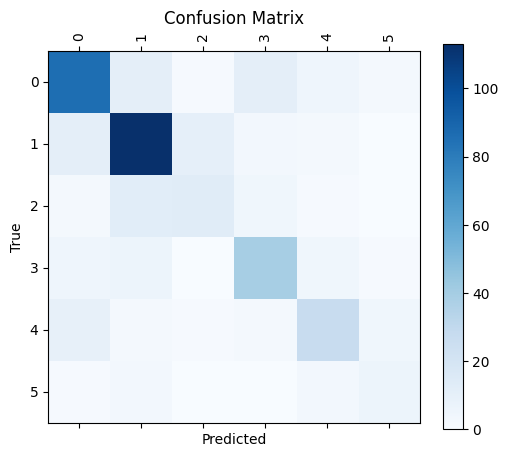

Running GridSearch over kernels and C...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'} 

Evaluating best model:
Accuracy: 0.710

              precision    recall  f1-score   support

           0       0.75      0.74      0.75       116
           1       0.77      0.81      0.79       139
           2       0.52      0.41      0.46        32
           3       0.66      0.71      0.68        55
           4       0.64      0.60      0.62        45
           5       0.46      0.46      0.46        13

    accuracy                           0.71       400
   macro avg       0.63      0.62      0.63       400
weighted avg       0.71      0.71      0.71       400



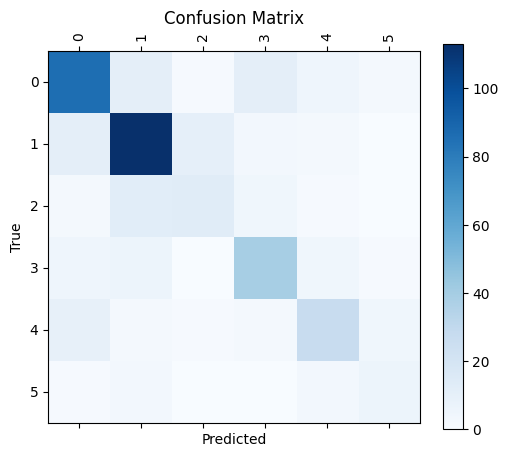


=== Alert System Demo ===
"I'm so angry about what happened today!" → anger (0.84) 🚨HIGH_RISK
"Feeling very sad and down…" → sadness (0.40) 
"I'm excited about my new job!" → joy (0.84) 
"That movie scared me so much!" → surprise (0.93) 

Saved trained pipeline to emotion_classifier.pkl


In [25]:
if __name__ == "__main__":
    # In a notebook environment, we can't use argparse directly.
    # Instead, define the arguments here:
    class Args:
        def __init__(self, data_path, output):
            self.data_path = data_path
            self.output = output

    # Define your data path and output file here
    # Replace '/content/test.csv' with the actual path to your data file
    data_path = '/content/test.csv'
    output_file = "emotion_classifier.pkl"

    args = Args(data_path, output_file)
    main(args)